In [2]:
# 📦 Essential Libraries
import pandas as pd
import numpy as np
import copy
import re

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Optional: set default Seaborn theme
%matplotlib inline  

# 📈 Statistics and Modeling
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 🧠 Machine Learning
from sklearn.model_selection import train_test_split, GroupShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# 🗃️ Other
import kagglehub

# 🛠️ NLTK (Natural Language Processing)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 🛠️ Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [3]:
#Step 1. Load the data
train = pd.read_csv(r"C:\Users\chris\OneDrive\Documents\Data Science\Machine Learning\UnSup. ML C2\bbc_train.csv");
test = pd.read_csv(r"C:\Users\chris\OneDrive\Documents\Data Science\Machine Learning\UnSup. ML C2\BBC_test.csv");

train['Length'] = train['Text'].apply(lambda x: len(str(x).split()))



In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')  

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # remove non-word characters
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)
train['clean_text'] = train['Text'].apply(clean_text)
train.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,ArticleId,Text,Category,Length,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,worldcom ex bos launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,325,german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,bbc poll indicates economic gloom citizen majo...
3,1976,lifestyle governs mobile choice faster bett...,tech,634,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,355,enron boss 168m payout eighteen former enron d...


In [5]:
# TF-IDF from train only
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(train['clean_text'])

# NMF topic modeling (unsupervised)
nmf = NMF(n_components=10, random_state=42)
W = nmf.fit_transform(X_train_tfidf)  # Document-topic matrix

le = LabelEncoder()
y_train = le.fit_transform(train['Category'])

# Split train into training and validation
W_train, W_val, y_train_split, y_val_split = train_test_split(W, y_train, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(W_train, y_train_split)

# Evaluate on validation
y_val_pred = clf.predict(W_val)
print("Validation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print(classification_report(y_val_split, y_val_pred, target_names=le.classes_))



Validation Accuracy: 0.9429530201342282
               precision    recall  f1-score   support

     business       0.96      0.88      0.92        75
entertainment       0.94      0.96      0.95        46
     politics       0.89      0.96      0.92        56
        sport       0.98      0.98      0.98        63
         tech       0.95      0.95      0.95        58

     accuracy                           0.94       298
    macro avg       0.94      0.95      0.94       298
 weighted avg       0.94      0.94      0.94       298



In [6]:
# Clean test set
test['clean_text'] = test['Text'].apply(clean_text)

# Transform test data using the SAME TF-IDF and NMF
X_test_tfidf = tfidf.transform(test['clean_text'])
W_test = nmf.transform(X_test_tfidf)

# Predict categories
test_preds = clf.predict(W_test)
test['Category'] = le.inverse_transform(test_preds)


In [7]:
test[['ArticleId', 'Text', 'Category']].head(10)


,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport
5,51,lewsey puzzle over disallowed try england s jo...,sport
6,2025,blair blasts tory spending plans tony blair ha...,politics
7,1479,former ni minister scott dies former northern ...,politics
8,27,career honour for actor dicaprio actor leonard...,entertainment
9,397,tsunami to hit sri lanka banks sri lanka s b...,business


In [8]:
test['Category'].value_counts()


Category
business         167
sport            165
politics         149
tech             138
entertainment    116
Name: count, dtype: int64

In [9]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(train['Category'])

# TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(train['clean_text'])

# Train/Val split
X_train, X_val, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf_sup = RandomForestClassifier(random_state=42)
clf_sup.fit(X_train, y_train_split)

# Evaluate
train_preds = clf_sup.predict(X_train)
val_preds = clf_sup.predict(X_val)

print("Train Accuracy:", accuracy_score(y_train_split, train_preds))
print("Validation Accuracy:", accuracy_score(y_val_split, val_preds))
print(classification_report(y_val_split, val_preds, target_names=le.classes_))


Train Accuracy: 1.0
Validation Accuracy: 0.9798657718120806
               precision    recall  f1-score   support

     business       0.96      0.99      0.97        75
entertainment       0.98      1.00      0.99        46
     politics       0.96      0.95      0.95        56
        sport       1.00      1.00      1.00        63
         tech       1.00      0.97      0.98        58

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



In [10]:
print("Unsupervised (NMF + classifier) val accuracy: ~0.94")
print("Supervised (TF-IDF + RandomForest) val accuracy: ~0.98")


Unsupervised (NMF + classifier) val accuracy: ~0.94
Supervised (TF-IDF + RandomForest) val accuracy: ~0.98


In [11]:
fractions = [0.1, 0.2, 0.5, 1.0]
results = []

for frac in fractions:
    if frac < 1.0:
        X_frac, _, y_frac, _ = train_test_split(X, y, train_size=frac, random_state=42, stratify=y)
    else:
        X_frac, y_frac = X, y  # Use all data when frac == 1.0

    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
        X_frac, y_frac, test_size=0.2, random_state=42, stratify=y_frac)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sub, y_train_sub)
    val_acc = accuracy_score(y_val_sub, clf.predict(X_val_sub))

    print(f"Training with {int(frac*100)}% of data: Validation Accuracy = {val_acc:.3f}")
    results.append({'TrainingSize': int(frac * 100), 'Accuracy': val_acc})  # use 'TrainingSize'


Training with 10% of data: Validation Accuracy = 0.833
Training with 20% of data: Validation Accuracy = 0.933
Training with 50% of data: Validation Accuracy = 0.926
Training with 100% of data: Validation Accuracy = 0.943


In [12]:
results.append({'TrainingSize': int(frac * 100), 'Accuracy': val_acc})

# Check the results list
print(results)

# Convert to DataFrame
df_eff = pd.DataFrame(results)
print(df_eff)



[{'TrainingSize': 10, 'Accuracy': 0.8333333333333334}, {'TrainingSize': 20, 'Accuracy': 0.9333333333333333}, {'TrainingSize': 50, 'Accuracy': 0.9261744966442953}, {'TrainingSize': 100, 'Accuracy': 0.9429530201342282}, {'TrainingSize': 100, 'Accuracy': 0.9429530201342282}]
   TrainingSize  Accuracy
0            10  0.833333
1            20  0.933333
2            50  0.926174
3           100  0.942953
4           100  0.942953


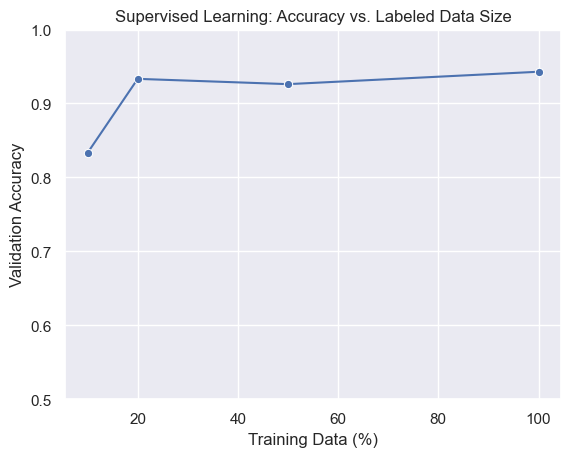

In [13]:
df_eff = pd.DataFrame(results)

# Ensure you're using 'TrainingSize' here
sns.lineplot(data=df_eff, x='TrainingSize', y='Accuracy', marker='o')
plt.title("Supervised Learning: Accuracy vs. Labeled Data Size")
plt.xlabel("Training Data (%)")
plt.ylabel("Validation Accuracy")
plt.ylim(0.5, 1.0)
plt.show()

